# HF Radar

This notebook intends to read and process some basic HF radar data to test and implement these into the automatic report system.

## Intentions to implement

1) Power spectra of U & V vectors for nearest grid point @the Buoy de Ibiza

2) 4th order butterworth filter(?):
<ul>
<li>low-pass data T>256h (v $<$ 0.0039)</li>
<li>dirunal-pass data T~24h (v ~ 0.042)</li>
<li>semi-diurnal pass data T~12h (v ~ 0.083)</li>
<li>inertial pass data T~17h (v ~ 0.058)</li>
</ul>
(After "Surface circulation in the Gulf of Trieste (northern Adriatic Sea) from radar, model, and ADCP comparisons" <a href="http://onlinelibrary.wiley.com/doi/10.1002/2013JC009261/pdf">Cosoli et al</a>)

3) Plot vectors upon map

4) Temporal and spatial availability

5) Gridded colormaps of spatial availability

6) Signal to Noise + other definitions...

7) Maximum range and number of vectors(?)

8) Average radial bearing(?)

9) Average radial bearing difference



In [1]:
%matplotlib inline
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import datetime, time, calendar
import matplotlib.text as text
import matplotlib as mpl
from matplotlib import dates

In [2]:
mpl.rcParams.update({'font.size': 20})
hfmt = dates.DateFormatter('%d %B')
datafile = ("http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/2016/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_2016-05.nc")
timeinit,timeend = datetime.datetime(2016, 5, 1, 0, 0),datetime.datetime(2016, 5, 31, 23, 59)
tmin,tmax = time.mktime(timeinit.timetuple()), time.mktime(timeend.timetuple())

find closest buoy grid point

In [3]:
with netcdf.Dataset(datafile,'r+', format='NETCDF4') as nc:
    pressure_time = nc.variables['time'][:]
    goodtime = np.where(np.logical_and((pressure_time<=tmax), (pressure_time>=tmin)))[0]
    pressure = nc.variables['U'][goodtime]
    v = nc.variables['V'][goodtime]
    pressure_time = pressure_time[goodtime]
    lat = nc.variables['LAT'][:]
    lon = nc.variables['LON'][:]

In [4]:
buoy_lat = 38.82445
buoy_lon = 0.783667
print lat
print lon
closest_lat_idx = np.searchsorted(lat,buoy_lat)
closest_lon_idx = np.searchsorted(lon,buoy_lon)-1

print 'closest grid point: ' + str(lat[closest_lat_idx]) + ' ' + str(lon[closest_lon_idx])

[ 38.323   38.35    38.377   38.4041  38.4311  38.4581  38.4851  38.5122
  38.5392  38.5662  38.5933  38.6203  38.6473  38.6743  38.7014  38.7284
  38.7554  38.7824  38.8094  38.8365  38.8635  38.8905  38.9175  38.9446
  38.9716  38.9986  39.0256  39.0527  39.0797  39.1067]
[ 0.50384  0.53833  0.57282  0.60732  0.64181  0.6763   0.7108   0.74529
  0.77978  0.81428  0.84877  0.88326  0.91776  0.95225  0.98674  1.02124
  1.05573  1.09022  1.12472  1.15921  1.1937   1.2282   1.26269  1.29718
  1.33168  1.36617  1.40066]
closest grid point: 38.8365 0.77978


In [5]:
len(pressure_time)
print type(pressure)
print pressure.shape
#print pressure[:,closest_lat_idx,closest_lon_idx]
buoy_hf_grid_data_u = pressure[:,closest_lat_idx,closest_lon_idx]
buoy_hf_grid_data_v = v[:,closest_lat_idx, closest_lon_idx]

<type 'numpy.ndarray'>
(742, 30, 27)


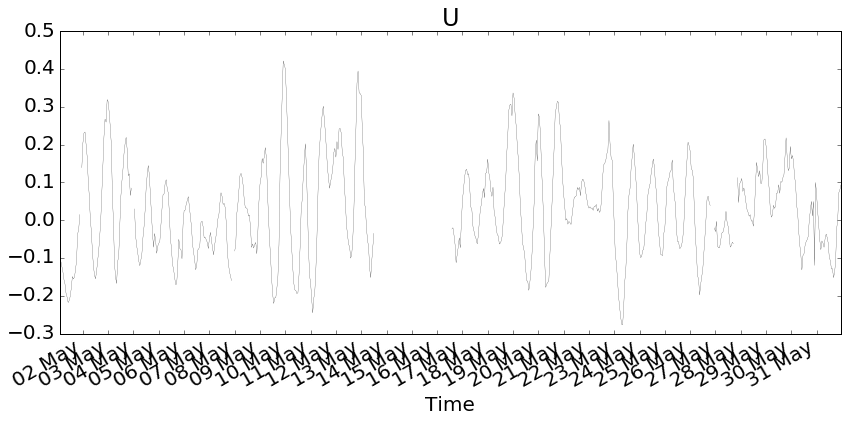

In [6]:
dts = map(datetime.datetime.fromtimestamp, pressure_time) 
fds = dates.date2num(dts)
# Make a plot
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(fds,buoy_hf_grid_data_u, 'k', lw=0.2)
plt.xlabel('Time')
plt.ylabel('', ha='right', rotation=0)
plt.title('U', fontsize=24)
ax.set_xlim(fds[0], fds[-1])
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
plt.show()

In [7]:
from scipy import signal

In [8]:
Ts = 3600.     # sampling interval
Fs = 1./Ts;  # sampling rate
print("Sampling rate = %s Hertz" %(Fs))

Sampling rate = 0.000277777777778 Hertz


(array([ 20,  69,  70, 164, 165, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371,
       618, 620, 640, 641, 642]),)
0.000277777777778


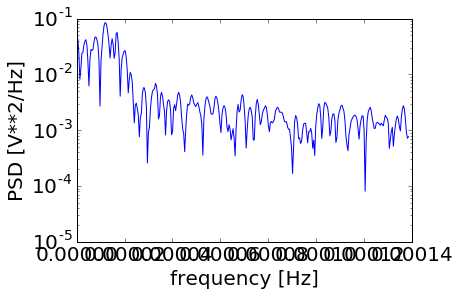

In [9]:
print np.where(np.isnan(buoy_hf_grid_data_u))
nan_idx = ~np.isnan(buoy_hf_grid_data_u)
frq, Pxx_den = signal.periodogram(buoy_hf_grid_data_u[nan_idx], Fs, 'flattop', scaling='spectrum')

print Fs

plt.semilogy(frq, np.sqrt(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()



In [84]:
np.where(frq>0.0001)[0]

array([238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329])

In [10]:
indexlow = np.where((frq<=0.0001) & (frq>=2e-6))[0]
indexhigh = np.where(frq>0.0001)[0]
frq_low = frq[indexlow]
frq_high = frq[indexhigh]
Pxx_den_low = Pxx_den[indexlow]
Pxx_den_high = Pxx_den[indexhigh]
nmaxlow = np.argmax(Pxx_den_low)
nmaxhigh = np.argmax(Pxx_den_high)

In [11]:
peaklow = str(np.around(1/(frq_low[nmaxlow])/3600., decimals=2))
print("Period of main peak in hours: %s" %(peaklow))

Period of main peak in hours: 23.54


In [12]:
peakhigh = str(np.around(1/(frq_high[nmaxhigh])/60., decimals=2))
print("Period of main peak in minutes: %s" %(peakhigh))

Period of main peak in minutes: 160.73


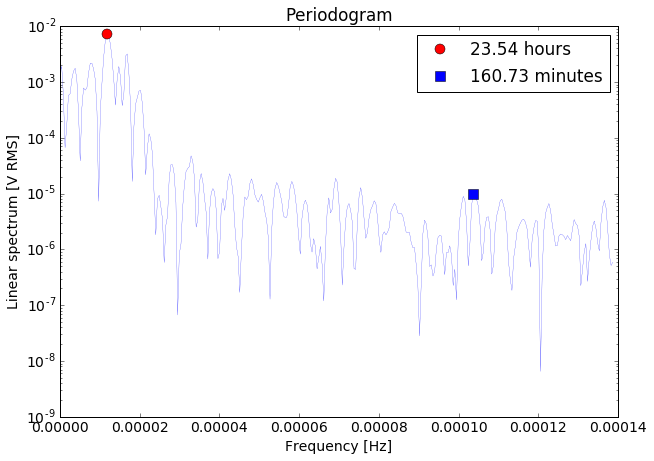

In [13]:
mpl.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 7))
plt.semilogy(frq, Pxx_den, linewidth=0.2)
plt.semilogy(frq_low[nmaxlow], Pxx_den_low[nmaxlow], 'ro', ms=10, label= peaklow + ' hours')
plt.semilogy(frq_high[nmaxhigh], Pxx_den_high[nmaxhigh], 'bs', ms=10, label= peakhigh + ' minutes')
plt.legend(loc='upper right', numpoints=1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
#plt.xlim(-0.00005, 0.0085)
plt.title('Periodogram')
plt.show()

In [42]:
from mpl_toolkits.basemap import Basemap

In [15]:
plt.rcParams['figure.figsize'] = 12, 12
m = Basemap(projection='merc', llcrnrlat=38.0, urcrnrlat=40.25,\
            llcrnrlon=0.25, urcrnrlon=3.5, lat_ts=35., resolution='h')

In [25]:
print lon.shape
print lat.shape
longrid, latgrid = np.meshgrid(lon, lat)
longrid2, latgrid2 = m(longrid, latgrid)
print longrid2.shape
print latgrid2.shape
print pressure.shape
print uvnorm.shape

(27,)
(30,)
(30, 27)
(30, 27)
(742, 30, 27)
(742, 30, 27)


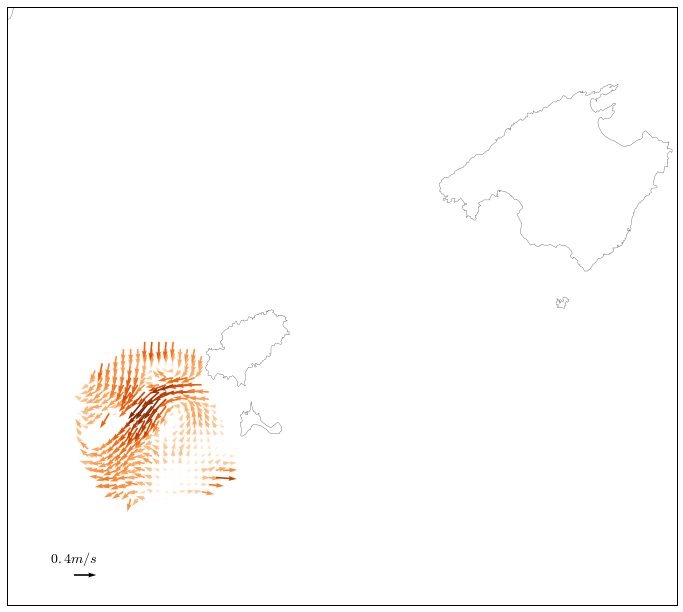

In [48]:
m.drawcoastlines(linewidth=.25, zorder=4)
time_idx = 2


uvnorm = (pressure*pressure + v*v)**0.5
cmap = plt.cm.Oranges
Q = m.quiver(longrid2, latgrid2, pressure[time_idx,:,:], v[time_idx,:,:], uvnorm[time_idx,:,:], cmap=cmap, scale=12)
qk = plt.quiverkey(Q, 0.1, 0.05, 0.4, r'$0.4 m/s$',
                   fontproperties={'weight': 'bold'})
plt.show()

In [49]:
b, a = signal.butter(4, 0.5, 'low')
output_signal = signal.filtfilt(b, a, frq)

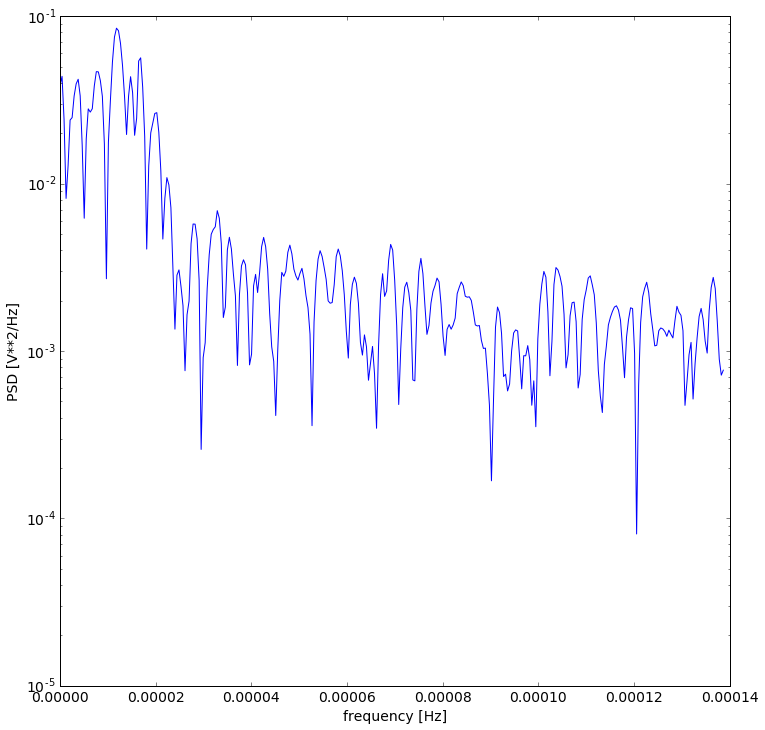

In [52]:
plt.semilogy(output_signal, np.sqrt(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()